In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt

from torchvision.io import read_image

import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

import torchvision.transforms.functional


# https://www.kaggle.com/code/mateuszbuda/brain-segmentation-pytorch

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        self.smax = nn.Softmax(dim = 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        #print ("dec1 dims", dec1.shape)
        #print ("convolution dims", self.conv(dec1).shape)
        #print ("output dims", self.smax(self.conv(dec1)).shape)

        return self.smax(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [2]:
# Sample Input
input_tensor = torch.randn([1, 4, 240, 240, 155]) # Each image 240x240 (155 slices)
input_tensor = input_tensor[0, :, :, :, :]
input_tensor = input_tensor.permute(3, 0, 1, 2)
print (input_tensor.shape, "[number of samples, num of modalities, 240x240]")

torch.Size([155, 4, 240, 240]) [number of samples, num of modalities, 240x240]


In [3]:
# Test layers
print ("Initial dimensions", input_tensor[1].shape)

"""layer1 = DoubleConvolution(4, 64)
print ("Double convolution", layer1(input_tensor[1]).shape)

layer2 = DownSample ()
print ("Downsampling", layer2(input_tensor[1]).shape)"""

model_input = input_tensor[1][:,:,:].unsqueeze(dim = 0)
model = UNet(4, 4)
#print("model dimensions", model(model_input).shape)
#print(model(model_input)[0][1])

out = model(model_input)
"""for i in out:
    for k in i: 
        print(k)"""

print (torch.sum(out, dim=1).shape)
print (torch.min(out), torch.max(out))

Initial dimensions torch.Size([4, 240, 240])
torch.Size([1, 240, 240])
tensor(0.0295, grad_fn=<MinBackward1>) tensor(0.7242, grad_fn=<MaxBackward1>)


In [4]:
"""
0: Background - This class represents the healthy brain tissue and is the majority class in the dataset.
1: Necrosis and Non-Enhancing Tumor - This class represents the non-enhancing tumor and the necrotic core of the enhancing tumor.
2: Edema - This class represents the edema surrounding the tumor.
3: Enhancing Tumor - This class represents the enhancing tumor."""

class BraTS2021Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.patient_ids = os.listdir(data_dir)

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        scan_files = [os.path.join(self.data_dir, patient_id, f'{patient_id}_{modality}.nii.gz')
                      for modality in ['t1', 't2', 't1ce', 'flair']]
        mask_file = os.path.join(self.data_dir, patient_id, f'{patient_id}_seg.nii.gz')

        # Load scan files and concatenate into a 4-channel tensor
        # In the BraTS dataset specifically, each patient has four MRI scans available: 
        # T1-weighted, T1-weighted with contrast enhancement (T1ce), T2-weighted, and FLAIR. 
        # By concatenating these four scans into a single 4-channel tensor, we can provide 
        # the model with more information about the anatomy being imaged.
        
        scans = []
        for scan_file in scan_files:
            scan_data = nib.load(scan_file).get_fdata()
            scans.append(scan_data)
        scans_tensor = np.stack(scans, axis=0)
        
        # Load mask file and convert to integer labels
        mask_data = nib.load(mask_file).get_fdata()
        mask_tensor = (mask_data > 0).astype(np.int64) + (mask_data == 4).astype(np.int64) * 2
        
        # Normalize scans and convert to PyTorch tensor
        scans_tensor -= np.mean(scans_tensor)
        scans_tensor /= np.std(scans_tensor)
        scans_tensor = torch.from_numpy(scans_tensor).float()
        
        # Convert mask to PyTorch tensor
        mask_tensor = torch.from_numpy(mask_tensor).long()
        
        return scans_tensor, mask_tensor

Scan tensor shape: torch.Size([4, 240, 240, 155])
Mask tensor shape: torch.Size([240, 240, 155])


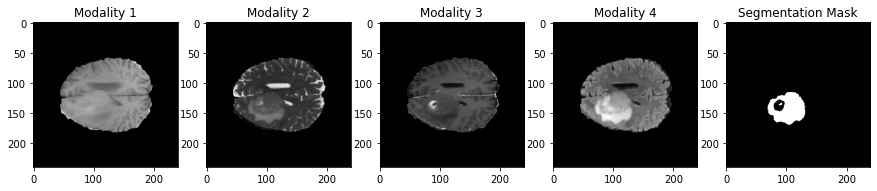

In [5]:
# Test the dataset

data_dir = 'C:/Users/alist/WorkCodes/Datasets/BRATS2021TRAINDATASET'
dataset = BraTS2021Dataset(data_dir)

# Load a single patient's MRI scan and segmentation mask
patient_idx = 1
scan, mask = dataset[patient_idx]

new_tensor = torch.zeros_like(mask) # Initialize new tensor with all zeros
new_tensor[mask == 1] = 1 
mask = new_tensor

# Print shape of scan and mask tensors
print('Scan tensor shape:', scan.shape)
print('Mask tensor shape:', mask.shape)

# Visualize the scan and mask using matplotlib
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(4):
    axs[i].imshow(scan[i][:, :, 100], cmap='gray')
    axs[i].set_title(f'Modality {i+1}')
axs[4].imshow(mask[:, :, 100], cmap='gray')
axs[4].set_title('Segmentation Mask')
plt.show()

In [6]:
import torch.utils.data

# Define split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the whole dataset into train and test dataset. Is validation needed?
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
#Clean all memory unused
import gc

print(torch.cuda.memory_summary())

torch.cuda.empty_cache()
gc.collect() #force garbage collection
print(f"Current GPU memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [8]:
print(f"Current GPU memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

Current GPU memory usage: 0.00 MB


In [9]:
if torch.cuda.is_available():
    device = torch.cuda.get_device_name(0)
    print('My GPU is correctly configured. GPU device name:', device)
else:
    print('No GPU available')
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(4, 4).to(device)

My GPU is correctly configured. GPU device name: NVIDIA GeForce RTX 3080 Laptop GPU


In [10]:
def Dice(output, target, eps=1e-5):
        target = target.float()
        num = 2 * (output * target).sum()
        den = output.sum() + target.sum() + eps
        return 1.0 - num/den

class softmax_dice(nn.Module):
    '''
    The dice loss for using softmax activation function
    :param output: (b, num_class, d, h, w)
    :param target: (b, d, h, w)
    :return: softmax dice loss
    '''
    def __init__(self):
        super(softmax_dice, self).__init__()
        
    def forward(self, output, target):
        target[target == 4] = 3 
        output = output.cuda()
        target = target.cuda()
        loss0 = Dice(output[:, 0, ...], (target == 0).float())
        loss1 = Dice(output[:, 1, ...], (target == 1).float())
        loss2 = Dice(output[:, 2, ...], (target == 2).float())
        loss3 = Dice(output[:, 3, ...], (target == 3).float())

        return loss1 + loss2 + loss3 + loss0 #, 1-loss1.data, 1-loss2.data, 1-loss3.data

In [14]:
"""
NEW TRAINING
"""

# Define hyperparameters
learning_rate = 0.001
num_epochs = 1

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

# Define loss function and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = softmax_dice()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Load checkpoint ==============================
checkpoint = torch.load('checkpoint.pth')

# Extract relevant data from checkpoint
#epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#loss = checkpoint['loss']
# ==============================================

softmax = nn.Softmax(dim = 1)

model.train()

running_loss = 0

for epoch in range(num_epochs):
    
    running_loss = 0.0
    totalTestLoss = 0

    model.train()

    for counter, (images, labels) in enumerate(train_loader):
        set_images = images.permute(4, 0, 1, 2, 3)[:, 0, :, :, :].cuda()  # [batch, 4, 240, 240, 155] => [155, 4, 240, 240]
        set_labels = labels.permute(3, 0, 1, 2)[:, 0, :, :].cuda() # [batch, 240, 240, 155] => [155, 240, 240]
        
        # ======= Select only a certain region

        set_images = set_images[40:115]
        set_labels = set_labels[40:115]

        # =======

        outputs = model(set_images)
        loss = criterion(outputs, set_labels.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print("running_loss", loss.item())
        
        if counter % 20 == 19:
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            },  'checkpoint.pth')
            print( "epoch:", epoch + 3, "iteration:", counter, "Average cost function", running_loss/20)
            running_loss = 0


epoch: 3 iteration: 19 Average cost function 1.4201192200183868


KeyboardInterrupt: 

In [12]:
print (set_images.shape)

torch.Size([75, 4, 240, 240])


In [ ]:
"""
NEW TRAINING
"""

"""# Define hyperparameters
learning_rate = 0.01
num_epochs = 1

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Load checkpoint ==============================
checkpoint = torch.load('checkpoint.pth')
#model.load_state_dict(checkpoint['model_state_dict'])


# Extract relevant data from checkpoint
#epoch = checkpoint['epoch']
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#loss = checkpoint['loss']
# ==============================================

softmax = nn.Softmax(dim = 1)

model.train()

for epoch in range(num_epochs):
    
    running_loss = 0.0
    totalTestLoss = 0

    model.train()

    for counter, (images, labels) in enumerate(train_loader):
        set_images = images.permute(4, 0, 1, 2, 3)[:, 0, :, :, :].cuda()  # [batch, 4, 240, 240, 155] => [155, 4, 240, 240]
        set_labels = labels.permute(3, 0, 1, 2)[:, 0, :, :].cuda() # [batch, 240, 240, 155] => [155, 240, 240]

        image_chunks = torch.chunk(set_images, chunks=5, dim=0)
        labels_chunks = torch.chunk(set_labels, chunks=5, dim=0)
        #print ("each image and mask", image_chunks[0].shape, labels_chunks[0].shape)

        for i in range(len(image_chunks)):
            mini_img = image_chunks[i].to(device)
            mini_lbl = labels_chunks[i].to(device)

            outputs = model(mini_img)
            loss = criterion(outputs, mini_lbl.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        # switch off autograd
        print("running_loss", running_loss)
        running_loss = 0
        #print(outputs)
        if counter % 10 == 9:
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            },  'checkpoint.pth')
            print("Successfully saved")"""


In [11]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

each inp torch.Size([1, 4, 240, 240])
output shape torch.Size([4, 240, 240])


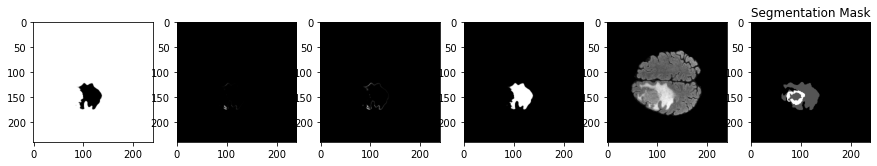

max 0: 1.0 min 0: 4.276914e-15
max 1: 0.0426022 min 1: 0.0
max 2: 0.16856053 min 2: 0.0
max 3: 1.0 min 3: 0.0
torch.Size([4, 240, 240])


In [18]:
"""patient_idx = 0 # Test on random
scan, mask = dataset[patient_idx]"""

"""for i in train_loader:
    scan = i[0][0]
    mask = i[1][0]
    break"""

#test_iterator = iter(test_loader)

# Get the first item from the iterator
a, b = next(test_iterator)
scan, mask = a[0], b[0]

scan = scan.permute(3,0,1,2).cuda()
mask = mask.permute(2,0,1)

model.eval()

layer = 100

print ("each inp", scan[layer].unsqueeze(dim=0).shape)
out = model(scan[layer].unsqueeze(dim=0))

out = out[0, :, :, :]
print("output shape", out.shape)


############################
l1 = nn.Softmax(dim = 0)
#out = l1(out)
############################

fig, axs = plt.subplots(1, 6, figsize=(15, 5))
    
axs[0].imshow(out[0][:, :].cpu().detach().numpy(), cmap='gray')
axs[1].imshow(out[1][:, :].cpu().detach().numpy(), cmap='gray')
axs[2].imshow(out[2][:, :].cpu().detach().numpy(), cmap='gray')
axs[3].imshow(out[3][:, :].cpu().detach().numpy(), cmap='gray')

axs[4].imshow(scan[layer][3].cpu().detach().numpy(), cmap='gray') # second is modality
axs[5].imshow(mask[layer, :, :], cmap='gray')
axs[5].set_title('Segmentation Mask')
plt.show()

checkoutput = out.cpu().detach().numpy()

print ("max 0:", checkoutput[0].max(), "min 0:", checkoutput[0].min())
print ("max 1:", checkoutput[1].max(), "min 1:", checkoutput[1].min())
print ("max 2:", checkoutput[2].max(), "min 2:", checkoutput[2].min())
print ("max 3:", checkoutput[3].max(), "min 3:", checkoutput[3].min())
#print (mask[layer, :, :])
print(out.shape)


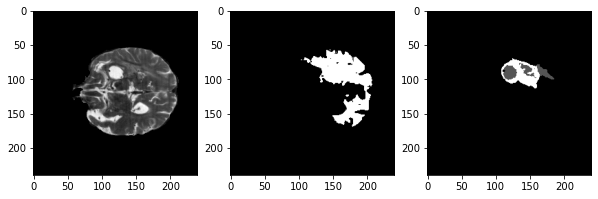

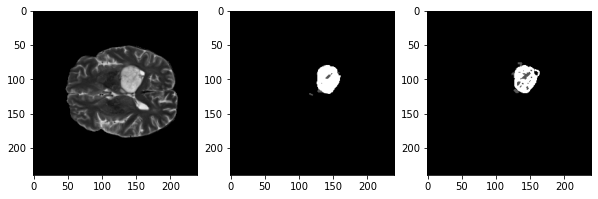

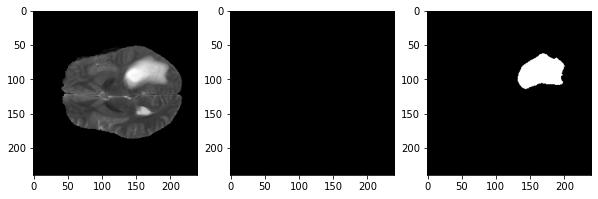

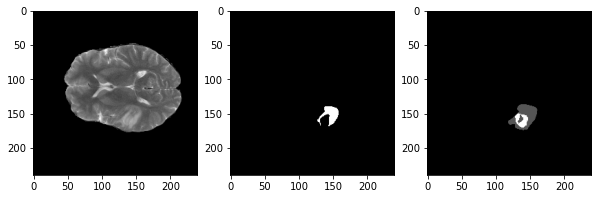

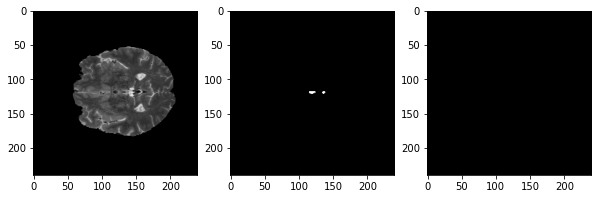

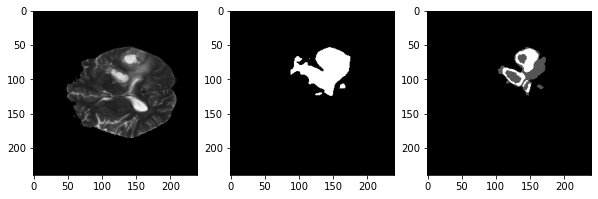

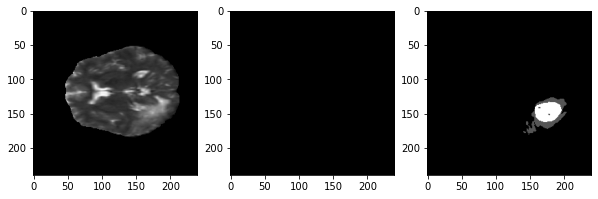

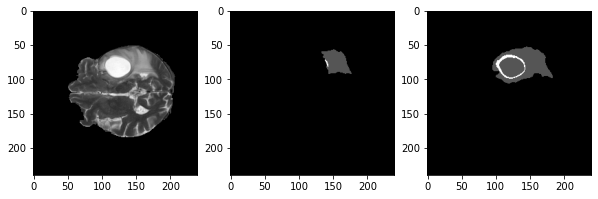

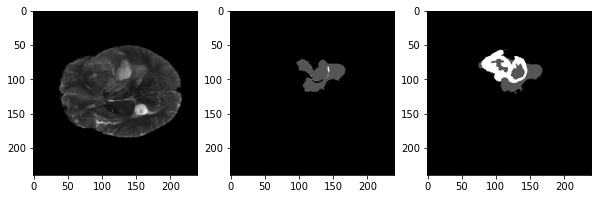

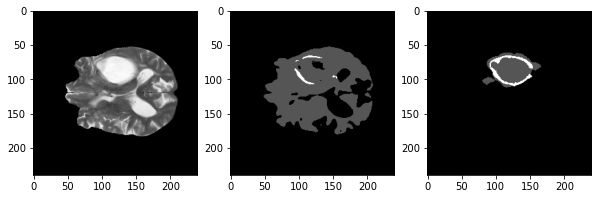

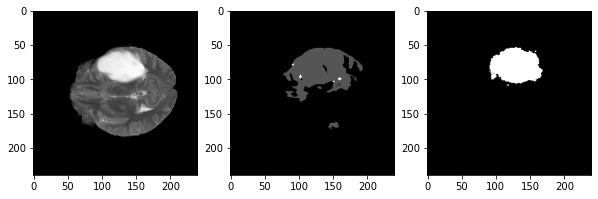

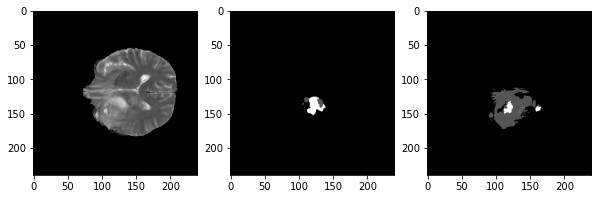

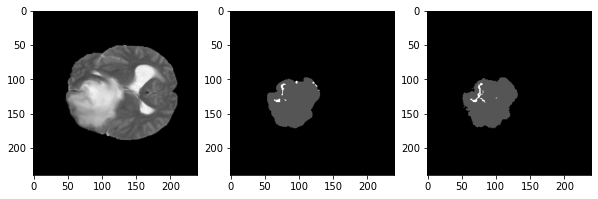

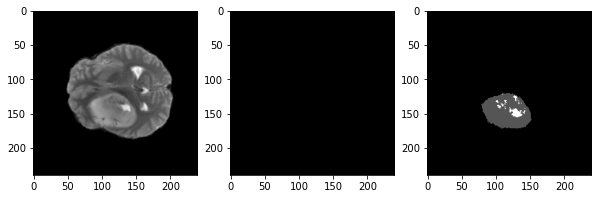

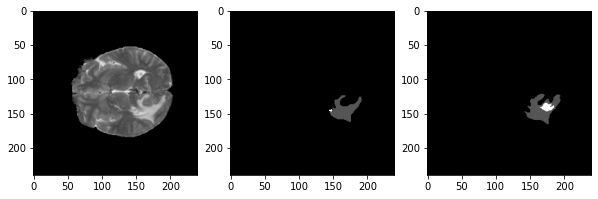

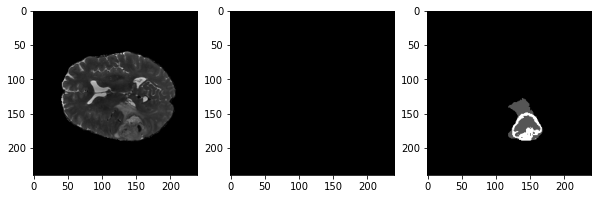

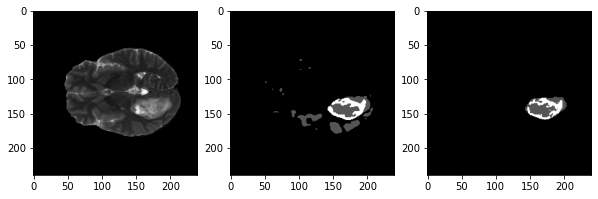

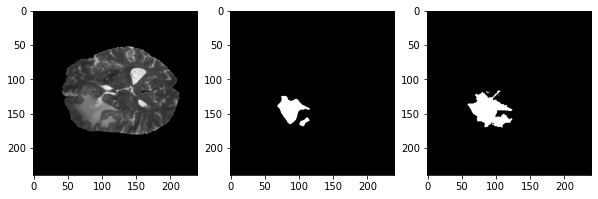

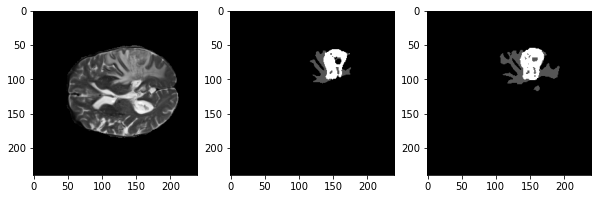

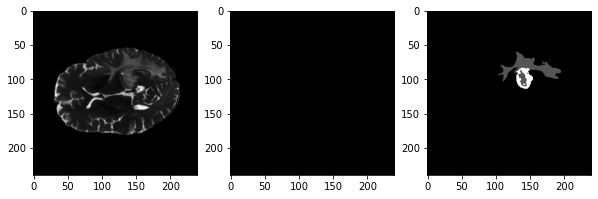

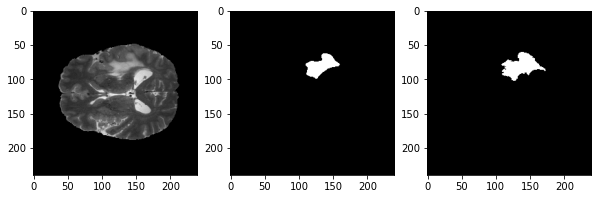

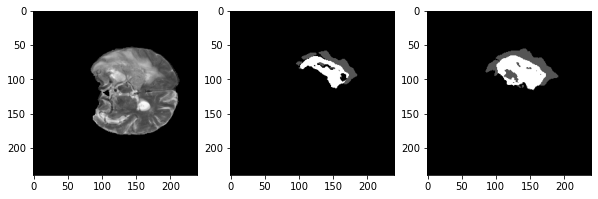

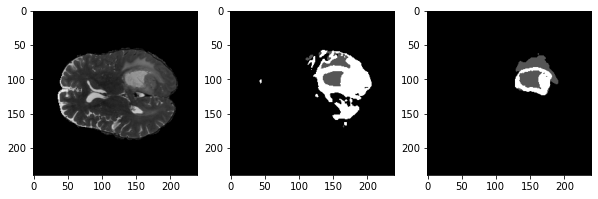

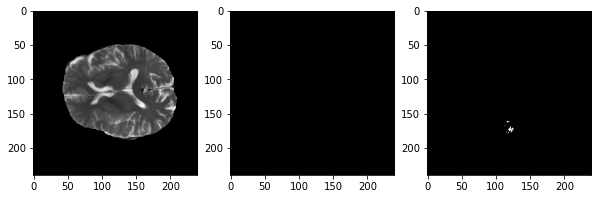

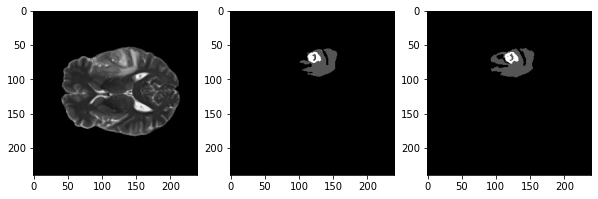

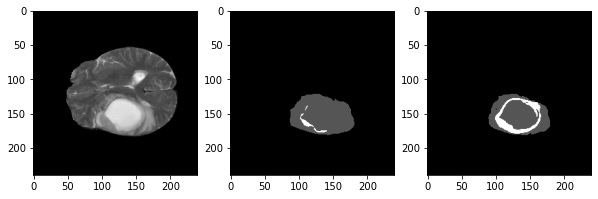

KeyboardInterrupt: 

In [19]:
"""
A few examples
"""
for i in train_dataset:
    scan = i[0].permute(3,0,1,2)
    mask = i[1].permute(2,0,1)
    #print (scan.shape, mask.shape) #([4, 240, 240, 155]) ([240, 240, 155])

    model.eval()
    layer = 70

    out = model(scan[layer].to(device).unsqueeze(dim = 0))

    class_index = torch.argmax(out, dim=1).cpu()
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))    
    axs[0].imshow(scan[layer][1][:, :].cpu().detach().numpy(), cmap='gray')
    axs[1].imshow(class_index[0][:, :].cpu().detach().numpy(), cmap='gray')
    axs[2].imshow(mask[layer][:, :].cpu().detach().numpy(), cmap='gray')
    plt.show()



In [25]:
from sklearn.metrics import jaccard_score
import torch

"""device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(4, 4).to(device)

checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])"""
model.eval()


total_iou = 0

for i in test_dataset:
    scan = i[0]
    #print (scan.shape)
    scan = scan.permute(3,0,1,2)[60:80]
    out = model(scan.to(device)).cpu()
    #print(out.shape)

    mask = i[1].permute(2, 0, 1)[60:80].cpu()  
    #print(mask.shape)
    class_index = torch.argmax(out, dim=1).cpu()
    # Compute the intersection over union (IoU) metric
    iou = jaccard_score(mask.flatten(), class_index.flatten(), average='macro')

    """fig, axs = plt.subplots(1, 2, figsize=(3, 1))    
    axs[0].imshow(class_index[0][:, :].cpu().detach().numpy(), cmap='gray')
    axs[1].imshow(mask[0][:, :].cpu().detach().numpy(), cmap='gray')
    plt.show()"""

    # Print the IoU metric
    print(f"IoU: {iou}")

    total_iou += iou
print ("total IOU score is", total_iou/250)

IoU: 0.3581178602280825
IoU: 0.4171019564442662
IoU: 0.7659511588106641
IoU: 0.2842702980183585
IoU: 0.3287482638888889
IoU: 0.36832743974614485
IoU: 0.6684055355713988
IoU: 0.7951696928365944
IoU: 0.2912894622811396
IoU: 1.0
IoU: 0.7306975674774719
IoU: 0.8269101570223759
IoU: 0.7155759598926692
IoU: 0.8642719405535435
IoU: 1.0
IoU: 0.42239957865478034
IoU: 0.6140880409026772
IoU: 0.4162093644213222
IoU: 0.2154039516542498
IoU: 0.43844216481003095
IoU: 0.7133469479712922
IoU: 0.37180885483225495
IoU: 0.48648288682474733
IoU: 0.30981695348994887
IoU: 1.0
IoU: 0.32799508101851854
IoU: 0.9055968868132961
IoU: 0.6441233571871309
IoU: 0.7486264507826963
IoU: 0.32831028135999063
IoU: 0.42510363495800374
IoU: 0.6682442831744818
IoU: 0.33924519267219777
IoU: 0.33112152777777776
IoU: 0.4873687049091115
IoU: 0.4558370144693746
IoU: 0.3950132705308838
IoU: 1.0
IoU: 0.6558954538156211
IoU: 0.41935165945467806
IoU: 0.32588946893442755
IoU: 0.499875
IoU: 0.7611045023519628
IoU: 0.49977039930555556


In [15]:
print(out.shape)
print(mask.shape)

torch.Size([75, 4, 240, 240])
torch.Size([155, 240, 240])


In [14]:
print(class_index.shape)

torch.Size([75, 240, 240])
